# CNN 이미지 분류 - 전이학습 

In [1]:
# 경고(worning) 무시
import warnings
warnings.filterwarnings('ignore')

In [2]:
from flickrapi import FlickrAPI
from urllib.request import urlretrieve
from pprint import pprint
import os, time, sys

key = "6a77e04939b39922140fe0033ad87fbd"
secret = "867c278824b691dc"


def download(keyword, dir):  

    newdir = "./image/" + dir 
    
    if not os.path.exists(newdir):
        os.mkdir(newdir)    
        
    flickr = FlickrAPI(key, secret, format='parsed-json')
    res = flickr.photos.search(
      text = keyword,     
      per_page = 100,     
      media = 'photos',   
      sort = "relevance", 
      safe_search = 1,    
      extras = 'url_q, license')
    
    photos = res['photos']
   
    
    try:
        for i, photo in enumerate(photos['photo']):
            url_q = photo['url_q']
            filepath = './image/' + dir + '/' + str(i) + '.jpg'
            print(url_q)
            urlretrieve(url_q, filepath)
            time.sleep(1)
    except:
        import traceback
        traceback.print_exc()
        
def main():
#     download('dog animal', 'dog')
#     download('deer animal', 'deer')
#     download('cat animal', 'cat')
    print("download completed...")

if __name__ == '__main__':
    main()

download completed...


In [3]:
import numpy as np
from PIL import Image
import os, glob, random

outfile = "image/photos.npz" 
max_photo = 100 
photo_size = 32 
x = [] 
y = [] 

def main():    
    glob_files("./image/dog", 0)   
    glob_files("./image/deer", 1)
    glob_files("./image/cat", 2)
    
    np.savez(outfile, x=x, y=y)  
    print("Number of images : ", str(len(x)))

def glob_files(path, label): 
    files = glob.glob(path + "/*.jpg")
   
    num = 0
    for f in files:
        if num >= max_photo: break
        num += 1
        img = Image.open(f)
        img = img.convert("RGB")  
        img = img.resize((photo_size, photo_size))  
        img = np.asarray(img) 
        x.append(img)
        y.append(label)
        
if __name__ == '__main__':
    main()

Number of images :  300


#### 동물 종류별로 제대로 변환되었는지 이미지 확인하기

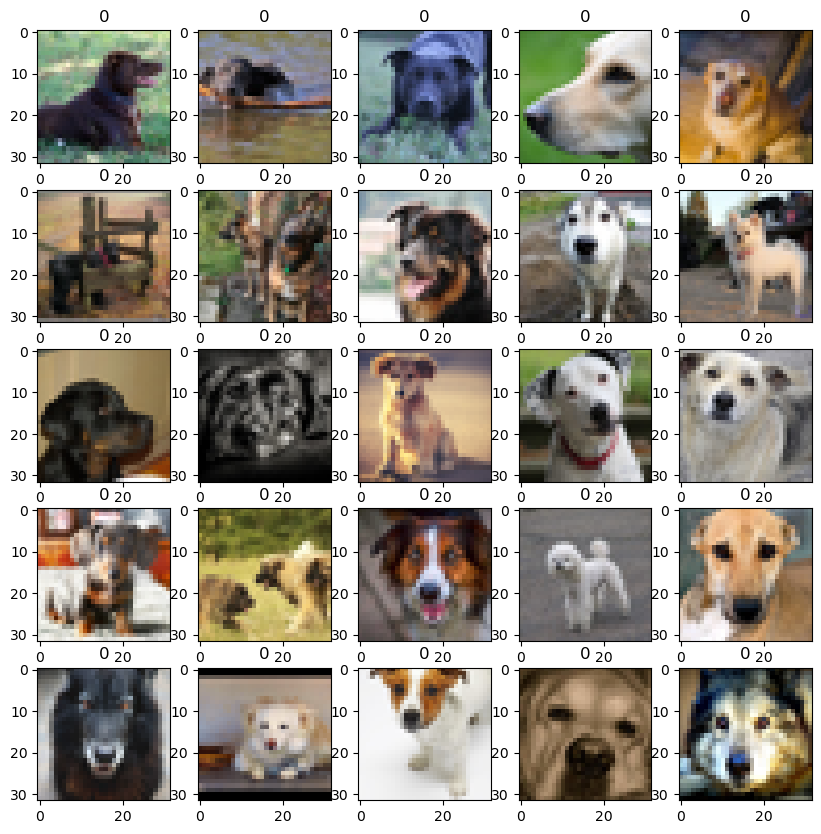

In [4]:
import matplotlib.pyplot as plt
import numpy as np

photos = np.load("image/photos.npz")
x = photos["x"]
y = photos["y"]

idx = 0  

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.title(y[i+idx])
    plt.imshow(x[i+idx])
    
plt.show()

###  데이타 전처리 


In [5]:
import tensorflow.keras
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

 
im_rows = 32  
im_cols = 32  
im_color = 3  
in_shape = (im_rows, im_cols, im_color)  
nb_classes = 3  

 
photos = np.load('image/photos.npz')
X = photos['x']
y = photos['y']
print((X.shape, y.shape))
print((X[0]))
 
X = x.reshape(-1, im_rows, im_cols, im_color)
X = x.astype('float32') / 255
print((X.shape))
print((X[0]))

 
y = to_categorical(y.astype('int32'), nb_classes) # nb_classes=3

((300, 32, 32, 3), (300,))
[[[164 199 142]
  [173 202 158]
  [180 210 168]
  ...
  [192 224 166]
  [207 231 173]
  [208 227 164]]

 [[136 174 126]
  [150 183 146]
  [161 192 153]
  ...
  [212 231 169]
  [196 222 157]
  [208 230 166]]

 [[136 171 130]
  [146 178 142]
  [156 181 139]
  ...
  [212 227 175]
  [196 215 163]
  [188 209 162]]

 ...

 [[ 78 111 109]
  [ 70 100  94]
  [ 92 125 117]
  ...
  [105 111 100]
  [ 80  85  74]
  [121 123 107]]

 [[108 121 121]
  [104 112 119]
  [101 121 117]
  ...
  [129 146 130]
  [104 138 117]
  [124 147 129]]

 [[119 137 128]
  [108 135 129]
  [110 147 137]
  ...
  [108 147 128]
  [115 160 135]
  [118 167 144]]]
(300, 32, 32, 3)
[[[0.6431373  0.78039217 0.5568628 ]
  [0.6784314  0.7921569  0.61960787]
  [0.7058824  0.8235294  0.65882355]
  ...
  [0.7529412  0.8784314  0.6509804 ]
  [0.8117647  0.90588236 0.6784314 ]
  [0.8156863  0.8901961  0.6431373 ]]

 [[0.53333336 0.68235296 0.49411765]
  [0.5882353  0.7176471  0.57254905]
  [0.6313726  0.752941

###  훈련, 검증, 테스트 데이타 구분


In [6]:
 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0)

 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2,
                                                  random_state=0)
 
print((X_train.shape, y_train.shape))
print((X_val.shape, y_val.shape))
print((X_test.shape, y_test.shape))

((192, 32, 32, 3), (192, 3))
((48, 32, 32, 3), (48, 3))
((60, 32, 32, 3), (60, 3))


## 2. 전이학습을 위하여 VGG16 사용


In [14]:
# cnn_model.py 파일 코드
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Input, models, layers, optimizers, metrics

# CNN 모델 정의하기
def def_model(in_shape, nb_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', 
                     input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    return model

def trans_model(in_shape, nb_classes):
    transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    transfer_model.trainable = False
    transfer_model.summary()
    
    # 우리의 모델을 설정합니다.
    finetune_model = models.Sequential()
    finetune_model.add(transfer_model)
    finetune_model.add(Flatten())
    finetune_model.add(Dense(512, activation='relu'))
    finetune_model.add(Dropout(0.5))
    finetune_model.add(Dense(nb_classes, activation='softmax'))
    return finetune_model


def get_model(in_shape, nb_classes):
    model = trans_model(in_shape, nb_classes)
    model.compile(
        loss='categorical_crossentropy',
        optimizer = Adam(1e-4),
        metrics=['acc'])
    return model

## CNN 모델 학습


###  ModelCheckpoint, Early_stopping  지정

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os


MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="./model/CNN_animal1.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

### 2) 모델 학습

In [9]:
# import cnn_model   

# im_rows = 32  
# im_cols = 32  
# im_color = 3  
# in_shape = (im_rows, im_cols, im_color) 
# nb_classes = 3  

# model = get_model(in_shape, nb_classes)
# model.summary()

# 896=3*3*3*32+32
# 9248=3*3*32*32+32
# 18496=3*3*32*64+64
# 36928=3*3*64*64+64
# 819712=1600*512+512




Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# import cnn_model   

im_rows = 32  
im_cols = 32  
im_color = 3  
in_shape = (im_rows, im_cols, im_color) 
nb_classes = 3  

model = get_model(in_shape, nb_classes)

history = model.fit(X_train, y_train,
          batch_size=32,
          epochs=120,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[checkpointer])

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Epoch 22/120
5/6 [========================>.....] - ETA: 0s - loss: 0.7618 - acc: 0.6438
Epoch 22: val_loss did not improve from 0.74013
6/6 [==============================] - 0s 58ms/step - loss: 0.8180 - acc: 0.5990 - val_loss: 0.7723 - val_acc: 0.6875
Epoch 23/120
5/6 [========================>.....] - ETA: 0s - loss: 0.7765 - acc: 0.6375
Epoch 23: val_loss did not improve from 0.74013
6/6 [==============================] - 0s 56ms/step - loss: 0.7599 - acc: 0.6406 - val_loss: 0.7678 - val_acc: 0.6875
Epoch 24/120
5/6 [========================>.....] - ETA: 0s - loss: 0.7760 - acc: 0.6313
Epoch 24: val_loss did not improve from 0.74013
6/6 [==============================] - 0s 56ms/step - loss: 0.7794 - acc: 0.6250 - val_loss: 0.7638 - val_acc: 0.6875
Epoch 25/120
5/6 [========================>.....] - ETA: 0s - loss: 0.7499 - acc: 0.6875
Epoch 25: val_loss did not improve from 0.74013
6/6 [==============================] - 0s 57ms/step - loss: 0.7546 - acc: 0.6875 - val_loss: 0.763

Epoch 54/120
5/6 [========================>.....] - ETA: 0s - loss: 0.5852 - acc: 0.7500
Epoch 54: val_loss did not improve from 0.73593
6/6 [==============================] - 0s 57ms/step - loss: 0.5656 - acc: 0.7604 - val_loss: 0.7372 - val_acc: 0.6667
Epoch 55/120
5/6 [========================>.....] - ETA: 0s - loss: 0.5327 - acc: 0.8125
Epoch 55: val_loss did not improve from 0.73593
6/6 [==============================] - 0s 59ms/step - loss: 0.5462 - acc: 0.7969 - val_loss: 0.7374 - val_acc: 0.6667
Epoch 56/120
5/6 [========================>.....] - ETA: 0s - loss: 0.5716 - acc: 0.7625
Epoch 56: val_loss did not improve from 0.73593
6/6 [==============================] - 0s 56ms/step - loss: 0.5727 - acc: 0.7656 - val_loss: 0.7361 - val_acc: 0.6667
Epoch 57/120
5/6 [========================>.....] - ETA: 0s - loss: 0.5710 - acc: 0.7688
Epoch 57: val_loss did not improve from 0.73593
6/6 [==============================] - 0s 57ms/step - loss: 0.5630 - acc: 0.7708 - val_loss: 0.739

## 5. 모델 평가

In [17]:
score = model.evaluate(X_test, y_test)
print(score)
print(('정답률 =', score[1], 'loss =', score[0]))

2/2 [==============================] - 0s 39ms/step - loss: 0.8149 - acc: 0.6500
[0.8149242401123047, 0.6499999761581421]
('정답률 =', 0.6499999761581421, 'loss =', 0.8149242401123047)


In [18]:
list(history.history.keys())

['loss', 'acc', 'val_loss', 'val_acc']

loss : 훈련 손실값
acc : 훈련 정확도
val_loss : 검증 손실값
val_acc : 검증 정확도

In [19]:
pprint(history.history)

{'acc': [0.2760416567325592,
         0.3229166567325592,
         0.34375,
         0.3645833432674408,
         0.3489583432674408,
         0.46875,
         0.4479166567325592,
         0.5208333134651184,
         0.4895833432674408,
         0.578125,
         0.5104166865348816,
         0.5677083134651184,
         0.5729166865348816,
         0.5677083134651184,
         0.6145833134651184,
         0.6302083134651184,
         0.5833333134651184,
         0.59375,
         0.5833333134651184,
         0.6145833134651184,
         0.578125,
         0.6302083134651184,
         0.6458333134651184,
         0.6458333134651184,
         0.671875,
         0.6302083134651184,
         0.6666666865348816,
         0.6875,
         0.6458333134651184,
         0.6822916865348816],
 'loss': [1.4048839807510376,
          1.2609223127365112,
          1.1829849481582642,
          1.0970697402954102,
          1.1034852266311646,
          1.0216360092163086,
          1.043160080909

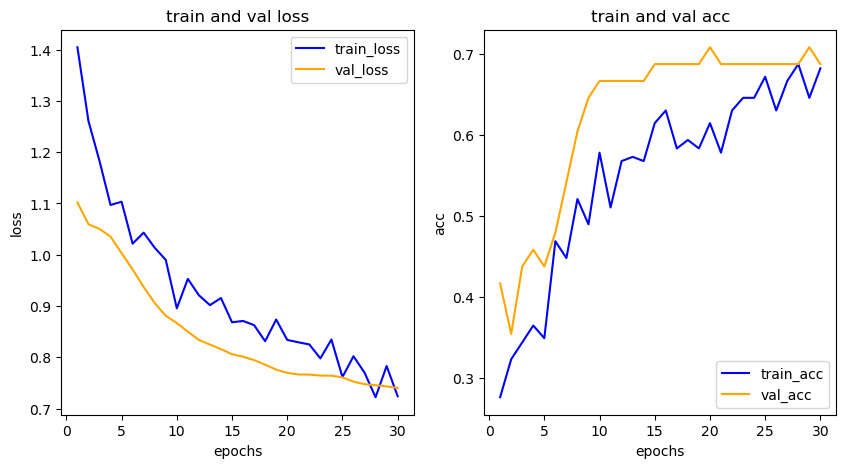

In [20]:
import matplotlib.pyplot as plt
his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 
epochs = list(range(1, len(loss) + 1))
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()
plt.show()